## First loading in modules

In [1]:
from masking_py3 import maskmaker
import numpy as np
import matplotlib.pyplot as plt
from psana import * 

## These next 3 cells load in the pre-processed h5 file

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

param_dict = {'spinewidth':2,
              'linewidth':4,
              'ticklength':6,
              'tickwidth':3,
              'ticklabelsize':20,
              'axislabelsize':20,
              'titlesize':25}
import matplotlib
def neaten_plot(neatenme, param_dict=param_dict):
    if isinstance(neatenme,matplotlib.figure.Figure):
        for ax in neatenme.axes:
            neaten_plot(ax)
        plt.tight_layout()
    elif isinstance(neatenme,matplotlib.axes.Axes):
        neatenme.tick_params(labelsize=param_dict['ticklabelsize'],length=param_dict['ticklength'],width=param_dict['tickwidth'])
        neatenme.xaxis.get_label().set_fontsize(param_dict['axislabelsize'])
        neatenme.yaxis.get_label().set_fontsize(param_dict['axislabelsize'])
        neatenme.title.set_fontsize(param_dict['titlesize'])
        for axis in ['top','bottom','left','right']:
            neatenme.spines[axis].set_linewidth(param_dict['spinewidth'])
        for line in neatenme.lines:
            line.set_linewidth(param_dict['linewidth'])

def plot_jungfrau(x,y,z,ax=None,shading='nearest',*args,**kwargs):
    if not ax:
        ax=plt.gca()
    for i in range(8):
        pcm = ax.pcolormesh(x[i],y[i],z[i],shading=shading,*args,**kwargs)
    return pcm

def createBinsFromCenters(centers):
    bins = []
    nc = centers.size
    for idx,c in enumerate(centers):
        if idx == 0:
            dc = np.abs( c - centers[idx+1])/2.
            bins.append(c-dc)
            bins.append(c+dc)
        elif idx == nc-1:
            dc = np.abs( c - centers[idx-1])/2.
            bins.append(c+dc)
        else:
            dc = np.abs( c - centers[idx+1])/2.
            bins.append(c+dc)
    return np.sort(np.array(bins))
            
def get_tree(f):
    """List the full tree of the h5 file"""
    def printname(name):  # needed because .visit needs callable
        print(name, type(f[name]))
    f.visit(printname)
    
def is_leaf(dataset):
    return isinstance(dataset,h5py.Dataset)

def get_leaves(f,saveto,verbose=False):
    def return_leaf(name):
        if is_leaf(f[name]):
            if verbose:
                print(name,f[name][()].shape)
            saveto[name] = f[name][()]
    f.visit(return_leaf)

def runNumToString(num):
    numstr = str(num)
    while len(numstr)<4:
        numstr = '0'+numstr
    return numstr

In [3]:
keys_to_combine = ['evr/code_137',
                   'jungfrau4M/azav_azav']
keys_to_sum = ['Sums/jungfrau4M_calib_xrayOn',
               'Sums/jungfrau4M_calib_dropped']
keys_to_check = ['UserDataCfg/jungfrau4M/azav__azav_q',
                'UserDataCfg/jungfrau4M/azav__azav_qbin',
                'UserDataCfg/jungfrau4M/azav__azav_qbins',
                'UserDataCfg/jungfrau4M/x',
                'UserDataCfg/jungfrau4M/y',
                'UserDataCfg/jungfrau4M/z',
                'UserDataCfg/jungfrau4M/azav__azav_matrix_q',
                'UserDataCfg/jungfrau4M/azav__azav_matrix_phi',
                'UserDataCfg/jungfrau4M/cmask',
                'UserDataCfg/jungfrau4M/Full_thres__Full_thres_thresADU',
                'UserDataCfg/jungfrau4M/Full_thres__Full_thres_bound',
                'UserDataCfg/jungfrau4M/common_mode_pars']

def combineRuns(runNumbers,folder,verbose=False):
    data_array = []
    for i,runNumber in enumerate(runNumbers):
        data = {}
        filename = f'{folder}cxil1035023_Run{runNumToString(runNumber)}.h5'
        print(filename)
        with h5py.File(filename,'r') as f:
            get_leaves(f,data,verbose=verbose)
            data_array.append(data)
    hf1 = h5py.File(filename, 'r')
    print(list(hf1.keys()))
#    for key in hf1['epicsAll']:
#        print(key)
    data_combined = {}
    for key in keys_to_combine:
        arr = np.squeeze(data_array[0][key])
        for data in data_array[1:]:
            arr = np.concatenate((arr,np.squeeze(data[key])),axis=0)
        data_combined[key] = arr
    run_indicator = np.array([])
    #for i,runNumber in enumerate(runNumbers):
    #    run_indicator = np.concatenate((run_indicator,runNumber*np.ones_like(data_array[i]['tt/FLTPOS'])))
    data_combined['run_indicator'] = run_indicator
    for key in keys_to_sum:
        arr = np.zeros_like(data_array[0][key])
        for data in data_array:
            arr += data[key]
        data_combined[key] = arr
    for key in keys_to_check:
        arr = data_array[0][key]
        for i,data in enumerate(data_array):
            if not np.array_equal(data[key],arr):
                print(f'Problem with key {key} in run {runNumbers[i]}')
        data_combined[key] = arr
    return data_combined

In [4]:
%%time
runNumbers = [22]
# runNumbers = [108]

folder = '/sdf/data/lcls/ds/cxi/cxil1035023/hdf5/smalldata/' #New Ana

data = combineRuns(runNumbers,folder=folder,verbose=False)

q = data['UserDataCfg/jungfrau4M/azav__azav_q']
qbin = data['UserDataCfg/jungfrau4M/azav__azav_qbin']
qbins = data['UserDataCfg/jungfrau4M/azav__azav_qbins']
x = data['UserDataCfg/jungfrau4M/x']
y = data['UserDataCfg/jungfrau4M/y']
z = data['UserDataCfg/jungfrau4M/z']
azav_azav = data['jungfrau4M/azav_azav']
matrix_q = data['UserDataCfg/jungfrau4M/azav__azav_matrix_q'].reshape(8,512,1024)
matrix_phi = data['UserDataCfg/jungfrau4M/azav__azav_matrix_phi'].reshape(8,512,1024)
on_sum = data['Sums/jungfrau4M_calib_xrayOn']
dropped_sum = data['Sums/jungfrau4M_calib_dropped']
run_indicator = data['run_indicator']
xrayOn_backup = data['evr/code_137'].astype(bool)
cmask = data['UserDataCfg/jungfrau4M/cmask'].astype(bool)
cmask1 = np.ones((8,512,1024))
cmask_tot = cmask #Can multiply to combine different masks here
threshold = data['UserDataCfg/jungfrau4M/Full_thres__Full_thres_thresADU']
cmpars = data['UserDataCfg/jungfrau4M/common_mode_pars']


/sdf/data/lcls/ds/cxi/cxil1035023/hdf5/smalldata/cxil1035023_Run0022.h5
['Sums', 'UserDataCfg', 'alvium_u1', 'damage', 'ebeam', 'epics', 'epicsOnce', 'event_time', 'evr', 'fiducials', 'gas_detector', 'ipm_dg2', 'ipm_hfx_dg2', 'ipm_hx2', 'jungfrau4M', 'lightStatus', 'proc_event_time', 'qadc0', 'qadc1', 'tt', 'ttRaw', 'ttRefit_IG', 'ttRefit_LFH']
CPU times: user 783 ms, sys: 1.57 s, total: 2.36 s
Wall time: 2.37 s


## Making the h5 file for the mask maker

In [8]:
h_file = h5py.File('/sdf/data/lcls/ds/cxi/cxil1035023/scratch/davidjr/run%d_100_stats.h5' % runNumbers[0], 'w')

onshots = np.where(xrayOn_backup == True)[0]
offshots = np.where(xrayOn_backup == False)[0]
detector_sums = np.sum(azav_azav, axis=1)

print(onshots.size)
print(offshots.size)


h_file.create_dataset('xray_front', data=on_sum)
h_file.create_dataset('dark_front', data=dropped_sum)
h_file.create_dataset('xray_shots', data = onshots.size)
h_file.create_dataset('dark_shots', data = offshots.size)
h_file.create_dataset('front_intensity', data = detector_sums)

h_file.close()

16146
119


## Next the tunables

In [17]:
datadir = '/sdf/data/lcls/ds/cxi/cxil1035023/scratch/davidjr/'
detector = 'front'
Nevents = 100000.
run = runNumbers[0]
filename = datadir+'run%d_%d_stats.h5' %(run, Nevents/1000.)
# whichmask = 'dark' #'dark' or 'xray'
whichmask = 'xray'

if whichmask == 'xray':
#	oldmask = np.load(datadir+'run%d_mask_dark.npy' %run)
	oldmask = np.load(datadir+'Mask_Jungfrau_T_Edge_Corrected.npy')
	JF_Image = on_sum    
#    oldmask = np.load(datadir+'Mask_Jungfrau_T_Edge_Corrected.npy')
if whichmask == 'dark':
	oldmask = np.load(datadir+'Mask_Jungfrau_T_Edge_Corrected.npy') #mask of just edge & unbonded pixels
	JF_Image = dropped_sum
    
#print(np.sum(oldmask))  
#for i in range(2,4):
#    oldmask[i,252:257,:] = 0
#    oldmask[i,:,766:769] = 0
#for i in range(4,6):
#    oldmask[i,252:257,:] = 0
#    oldmask[i,:,254:257] = 0
#for i in range(0,8):
#    oldmask[i,0,:] = 0
#    oldmask[i,511,:] = 0
#    oldmask[i,:,0] = 0
#    oldmask[i,:,1023] = 0

#np.save('Mask_Jungfrau_T_Edge_Corrected.npy', oldmask)


## Make the Mask

In [18]:
import h5py
hf = h5py.File(filename, 'r')
print(hf.keys())
print(np.sum(hf['dark_front'][0]))

<KeysViewHDF5 ['dark_front', 'dark_shots', 'front_intensity', 'xray_front', 'xray_shots']>
-4398180400.0


In [19]:
#maskmaker makes the mask, starting from the 'oldmask' input
#from masking_py3 import maskmaker
mm = maskmaker('cxil1035023', run, detector, filename, oldmask)

xray_image = np.copy(mm.xray)
dark_image = np.copy(mm.dark)

dark_front
dark_shots
front_intensity
xray_front
xray_shots


## Plot Average Detector Signal

In [ ]:
print('average detector signal')
print(np.average(mm.intensity))
plt.hist(mm.intensity)
plt.title('jungfrau intensity')
plt.ylabel('shot counts')
plt.xlabel('intensity per shot')
plt.show()

## Find Upper and Lower Bounds

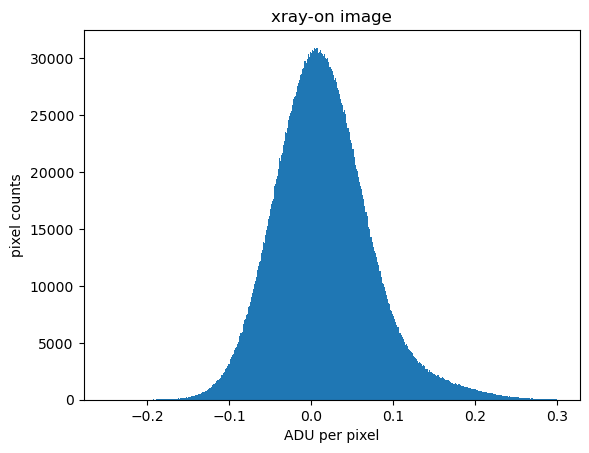

input the lower bound:


 -0.18


input the upper bound:


 0.28


In [20]:
###### print 'use the histogram to find lower and upper bounds'
if whichmask == 'xray':  
	plt.hist(xray_image.flatten(), bins=552, range = (-0.25, 0.3))
	plt.title('xray-on image')
if whichmask == 'dark':
	plt.hist(dark_image.flatten(), bins=100, range = (-0.25,0.3))
	plt.title('xray-off image run %d' % run)
plt.ylabel('pixel counts')
plt.xlabel('ADU per pixel')
plt.show()
#plt.savefig('run%d_dark.png' % run)

print('input the lower bound:')
lb = float(input())
print('input the upper bound:')
ub = float(input())

assert ub > lb

## Make new mask

In [21]:
name = datadir+'run%d_mask_%s.npy' %(run, whichmask)
newmask = mm(whichmask, lowerbound=lb, upperbound=ub, tolerance=2.5, name=name)
print(newmask.sum())
print(newmask.sum()/(8*512*1024))

4050265.0
0.96565842628479


In [22]:
print(np.unique(newmask))

[0. 1.]


## Show Xray On Jungfrau Image

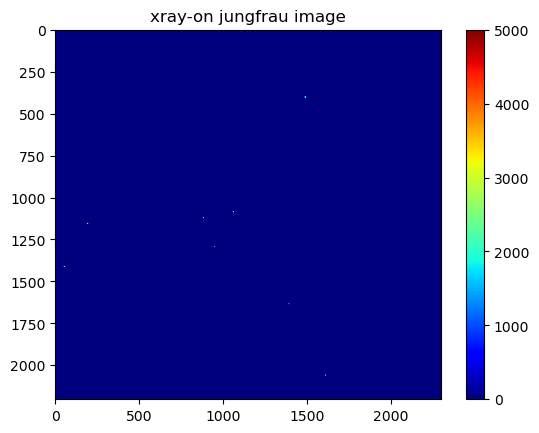

In [15]:
img = mm.det.image(mm.evt0, xray_image)
#plt.imshow(img, vmin=lb, vmax=ub, cmap = 'jet')
plt.imshow(img, cmap = 'jet', vmin = 0,vmax = 5000)
plt.colorbar()
plt.title('xray-on jungfrau image')
plt.show()

## Show Dark Image

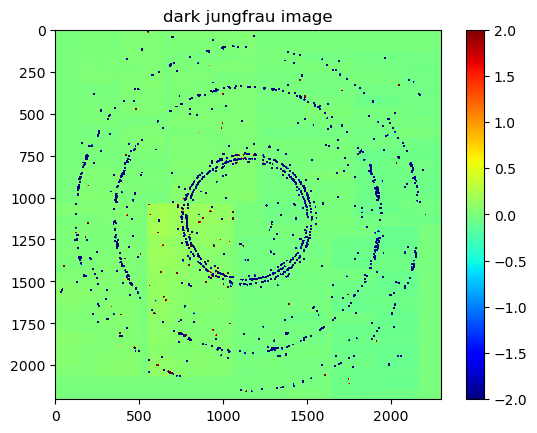

In [16]:
img = mm.det.image(mm.evt0, np.nan_to_num(dark_image))
plt.imshow(img, vmin=-2, vmax=2, cmap ='jet')
plt.title('dark jungfrau image')
plt.colorbar()
plt.show()

## Show Masked Image

In [ ]:
img = mm.det.image(mm.evt0, newmask* xray_image)
#plt.imshow(img, vmin=lb, vmax=ub)
plt.imshow(img, cmap = 'jet')# vmin=0, vmax=2,) 
plt.title('dark jungfrau image')
plt.colorbar()
plt.title('masked jungfrau')
plt.show()

In [ ]:
img = mm.det.image(mm.evt0, newmask)
plt.imshow(img, vmin=0, vmax=1.3, cmap = 'jet')
plt.title('Basic Mask')
plt.colorbar()
plt.show()
#plt.savefig('analysis_mask.png')

## Let's find the 'Bad T' sections and remove them

In [ ]:
Jungfrau_Test = newmask
sum_value_array_512 = np.zeros(512)
sum_value_array_1024 = np.zeros(1024)
for i in range(0,512):
    sum_value = np.sum(Jungfrau_Test[4,i,:])
    sum_value_array_512[i] = sum_value
for i in range(0, 1024):
    sum_value = np.sum(Jungfrau_Test[4,:,i])
    sum_value_array_1024[i] = sum_value
    
print(np.min(sum_value_array_512))
print(np.where(sum_value_array_512 == np.min(sum_value_array_512)))
print(np.min(sum_value_array_1024))
print(np.where(sum_value_array_1024 == np.min(sum_value_array_1024)))
print(sum_value_array_512[245:265]) #It looks like columns 252-257 should be omitted
print(sum_value_array_1024[245:265]) #It looks like rows 254-257 should be omitted in modules 4 and 5

reg_array = np.arange(1024)
flip_array = np.flip(reg_array)
print(flip_array[254]) 
print(flip_array[257]) #The results from 'flip array' indicate rows 766-769 should be omitted in modules 2 and 3

    